# 1. Overview
This notebook presents a comprehensive exploration and implementation of Softmax Regression and k-Nearest Neighbors (kNN) algorithms in Python. Focusing on multi class classification with the MNIST dataset. The notebook demonstrates building of these models from scratch, alongside comparisons with their Scikit-learn implementation.


# Table of Contents 
- [1. Overview](#overview)
- [2. Implementation of the Algorithms From Scratch](#implementation)
    - [2.1. Methodology of Softmax Regression](#methodSoftmax)
    - [2.2. Implementation of Softmax Regression](#implementationSoftmax)
    - [2.3. Methodology and Implementation of k-Nearest-Neighbours](#kNN)
- [3. Exploratory Data Analysis](#eda)
- [4. Training and Evaluation](#train)
- [5. Conclusion](#conclusion)

# 2. Implementation of The Algorithms From Scratch <a class="anchor" id="implementation"></a>
In this section, we will delve into how both these algorithms works and their implementations from scratch. First, we import the libraries.

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## 2.1 Methodology of Softmax Regression <a class="anchor" id="methodSoftmax"></a>
Here is an overview of the steps for the training phase: 
1. Given a data point, compute the linear combination $ z $ of weights $ W $ and inputs $ X $, computed as:
$
Z_i = \mathbf{W}_i^\top \mathbf{X} + b_i
$ where $ b $ is the bias for class $ i $.
2. Apply the softmax function to get probabilities for each class: $P(y = i | \mathbf{X}) = \frac{e^{Z_i}}{\sum_{j=1}^{K} e^{Z_j}} $ for $i$ = $1$ to $K$ where $ K $ is the number of classes.
3. Compute the error using the cross-entropy loss function: $ L_i = -\frac{1}{N} \sum_{n=1}^{N} \sum_{i=1}^{K} y_{ni}\log(P(y = i | \mathbf{X}_n))$. (Please check section 2.1.4 from the report for Detailed explanation of the loss function)
4. Use gradient descent to update weights and bias.
5. Repeat for a specified number of iterations which is also known as `epoch`.

And the steps for the prediction phase:

1. For a new data point, compute the linear combination of weights and inputs.
2. Apply the softmax function to get probabilities for each class.
3. Predict the class with the highest probability using argmax

For a detailed explanation please refer to section 2 of the report


## 2.2 Implementation of Softmax Regression <a class="anchor" id="implementationSoftmax"></a>
In building the Softmax Regression model, we decided to use an Object-Oriented approach. The reason is it's easier to manage the state of the weights, biases and learning rate. It's also clearer, scalable and reusable code. we will be following the  sklearn style and numpy style documentation.

In [2]:
class SoftMaxRegression():
    """
    Softmax Regression class for predicting the probabilities of different classes
    based on input features. 
    """
    def __init__(self, learning_rate=0.001, num_iters=1000, num_classes=None):
        """
        Parameters: 
            learning_rate: learning rate is the steps for gradient descent optimization.
            num_iters (epochs): number of iterations for the gradient descent algorithm
            num_classes: number of classes in the target variable
        """
        self.learning_rate = learning_rate
        self.num_iters = num_iters
        # array of weights of the model (initialized during training)
        self.weights = None 
        # array of bias of the model (initialized during training)
        self.bias = None
        self.num_classes = num_classes

        # array to record the loss during training
        self.training_loss = []
        # array to Record the loss during validation.
        self.validation_loss = []
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        Trains the softmax regression model by following steps:
        - Initialize weights and bias as zero arrays/matrices.
        - Apply one hot encoding for target y
        - Given a data point, compute the linear combination of weights and inputs.
        - Apply the softmax function to get probabilities for each class.
        - Compute the error using the cross-entropy loss function.
        - Use gradient descent to update weights and bias.
        - Repeat for a specified number of iterations.

        Parameters: 
            X: input features for training.
            y: target variable for training.
            X_val (optional): input features for validation.
            y_val (optional): target variable for validation.

        """
        # Initialize weights and bias as zero arrays/matrices
        num_samples, num_features = X.shape
        # get number of classes 
        self.num_classes = len(np.unique(y)) if self.num_classes is None else self.num_classes
        self.weights = np.zeros((num_features, self.num_classes))
        self.bias = np.zeros(self.num_classes)

        # arrays to store training and validation loss
        self.training_loss = []
        self.validation_loss = []

        # one hot encoding for target variable y taken from:
        # https://stackoverflow.com/questions/29831489/convert-array-of-indices-to-one-hot-encoded-array-in-numpy
        y_one_hot = np.eye(self.num_classes)[y]

        for i in range(self.num_iters):
            # print("epoch: ", i)
            # compute linear combination of weights and inputs
            scores = np.dot(X, self.weights) + self.bias
            # apply softmax function to get class probabilities
            probabilities = self.softmax(scores)

            # compute gradient for weights and bias
            dw = (1 / num_samples) * np.dot(X.T, (probabilities - y_one_hot))
            db = (1 / num_samples) * np.sum(probabilities - y_one_hot, axis=0)

            # update weights and bias using gradient descent
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            # compute training loss and add it to the array
            train_loss = self.compute_cost(X, y)
            self.training_loss.append(train_loss)

            # if validation data is provided, compute validation loss
            if X_val is not None and y_val is not None:
                val_loss = self.compute_cost(X_val, y_val)
                self.validation_loss.append(val_loss)

    def predict(self, X):
        """
        Testing/Predict steps:
        - For a new data point, compute the linear combination of weights and inputs.
        - Apply the softmax function to get probabilities for each class.
        - Predict the class with the highest probability.

        Paramters: 
            X: input feature 
        
        Returns: 
            list of the predicted class with the highest probability
        """
       
        # compute linear combination of weights and inputs
        scores = np.dot(X, self.weights) + self.bias
        # apply softmax function to get class probabilities
        probabilities = self.softmax(scores)
        # return the predicted class with the highest probability
        return np.argmax(probabilities, axis=1)

    @staticmethod
    def softmax(z):
        """
        converts scores (logits, linear combinations) to probabilities
        """
        # softmax function to convert scores into probabilities
        e_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return e_z / np.sum(e_z, axis=1, keepdims=True)
    
    def compute_cost(self, X, y):
        """
        compute the average cross entropy loss

        Parameters: 
            X: input feature
            Y: target labels

        Returns:
            computed average cross entropy loss in float. 
        """
        num_samples = X.shape[0]
        scores = np.dot(X, self.weights) + self.bias
        probabilities = self.softmax(scores)
        
        # Create one hot encoding for y
        y_one_hot = np.eye(self.num_classes)[y]
        
        # compute average cross-entropy loss
        loss = -np.sum(y_one_hot * np.log(probabilities)) / num_samples
        return loss
    
    def get_training_loss(self):
        """
        returns the training loss 
        """
        return self.training_loss
    
    def get_validation_loss(self):
        "returns the validation loss"
        return self.validation_loss
    
    def get_num_classes(self):
        "returns the number of classes"
        return self.num_classes

    def get_weights(self):
        "returns the weights"
        return self.weights
    

## 2.3. Methodlogy and Implementation of k-Nearest Neighbours <a class="anchor" id="kNN"></a>
kNN works in the context of classification by classifying a new data point based on how its neighbors are classified. the kNN Algorithm can be broken down into the following steps:
1. Choose the number of neighbours, which is denoted as $ k $.
2. Compute the distance of K number of neighbours.
3. get $ k $ nearest neighbours based on these distances.
4. For classification, the algorithm looks at the classes of these $ k $ neighbours and assigns the class to the new point based on a majority vote. 

For the distance metric, we use the euclidean distance to measure the shortest path between two points
$$
  d_{\text{euclidean}}(x, y) = \sqrt{\sum_{i=1}^{n} (x_i - y_i)^2}
$$

In [3]:
def compute_euclidean_distance(p1, p2):
    """ 
    compute the Euclidean (L2) distance between two points
    """
    return np.sqrt(np.sum((np.array(p1) - np.array(p2)) ** 2))

The steps to get $ k $ nearest neighbour are:
1. Compute the Euclidean distance $ d_{\text{euclidean}}$ between the point we want to classify, which is the testing pointand all the points in the training set.
2. Sort the lists of distances in an ascending order. from to each in the training set are then arranged in ascending order
3. Pick the top $ k $ points from this sorted list, which is the $ k $ nearest neighbours of the testing point. 

In [4]:
def get_neighbors(X_train, test_point, k):
    """ 
    get the k nearest neighbors of a test point in the training set.
    
    Parameters: 
        X_train: the training dataset 
        test_point, the data point that we want to find the nearest neighbors
        k: integer number that represents the nearest neighbors to find.

    Returns: 
        array of indices of the k nearest neighbors in the training dataset
    """

    # compute the euclidean distance from the test point to the all training points and store it in dists.
    dists = [compute_euclidean_distance(test_point, train_point) for train_point in X_train]
    # finds the indices of the k smallest distances and,
    # sorts the distances and return their indices using argsort then,
    # selects the indices corresponding to the k smallest distances
    k_inds = np.argsort(dists)[:k]
    # convert the numpy array of dists to a list to make it easier to handle
    return list(k_inds)  

After identifying the k nearest neighbours of a test point, we then need to determine the most common class among these neighbours which is the majority vote. The argmax selects the class c with the most neighbours.

In [5]:
def get_majority_vote(neighbors_classes):
    """
    get the majority vote (most common class) among the neighbors.

    Parameters:
        neighbors_classes: list of classes for the nearest neighbors

    Returns:
        The class that appears most frequently among the neighbors
    """

    class_count = {}
    for cls in neighbors_classes:
        if cls in class_count:
            class_count[cls] += 1
        else:
            class_count[cls] = 1

    # return most common class, taken from https://datagy.io/python-get-dictionary-key-with-max-value/
    return max(class_count, key=class_count.get)

Here is the full for the entire process of the kNN classification algorithm brought together in one function: 

In [6]:
def knn_predict(X_train, y_train, X_test, k=5):
    """
    Predicts the class of each test point using the kNN algorithm.

    For each point in the test set (X_test) get the k nearest neighbors
    from the training set (X_train) then predicts the class of each test point
    based on the majority vote from its neighbors.

    Paramters:
        X_train: list of the training dataset (features)
        y_train: list of classes for the training dataset
        X_test: list of test dataset (features) for which predictions are required
        k (optional, default = 5):  integer number of nearest neighbors to consider

    Returns:
        list of predicted classes for each test point
    """
    predictions = []
    for test_point in X_test:
        # find the indices of the k nearest neighbors
        k_inds = get_neighbors(X_train, test_point, k)
        # get the classes of the k nearest neighbors
        k_nearest_classes = [y_train[i] for i in k_inds]
        # determine the majority vote (most common) class among the neighbors
        majority_vote_class = get_majority_vote(k_nearest_classes)
        # append the predicted class to the predictions list
        predictions.append(majority_vote_class)

    # return the list of predicated classes (labels) 
    return predictions

We will test it on small sample of digits since it's computationaly expensive when dealing with a larger dataset. We will not use our own kNN for the full dataset.

In [7]:
from sklearn.datasets import load_digits
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# load sample of digits dataset.
digits = load_digits()
X, y = digits.data, digits.target

# split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# make predictions
y_pred = knn_predict(X_train, y_train, X_test, k=5)

# generate and print the classification report
report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        47
           3       0.98      1.00      0.99        54
           4       0.98      1.00      0.99        60
           5       0.98      0.98      0.98        66
           6       1.00      1.00      1.00        53
           7       1.00      0.98      0.99        55
           8       1.00      1.00      1.00        43
           9       0.97      0.95      0.96        59

    accuracy                           0.99       540
   macro avg       0.99      0.99      0.99       540
weighted avg       0.99      0.99      0.99       540



# 3. Exploratory Data Analysis <a class="anchor" id="eda"></a>
We will be using the MNIST handwritten digits dataset to classify grayscaled images of handwritten digits into ten labels (from 0 to 9).

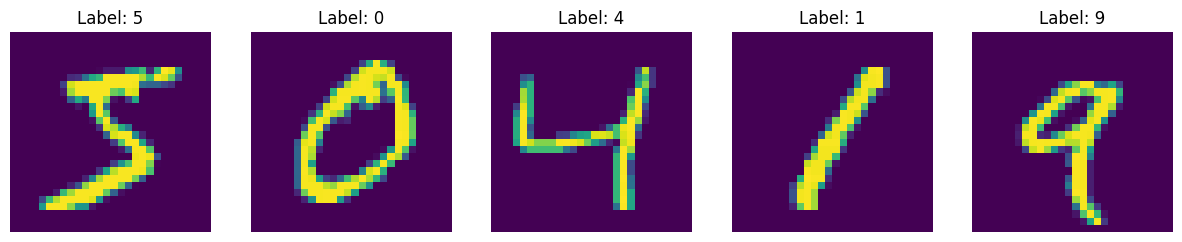

In [8]:
from sklearn.datasets import fetch_openml

# fetch the MNIST dataset
mnist_digits = fetch_openml('mnist_784', version=1, as_frame=False, parser="auto")

sns.color_palette("rocket", as_cmap=True)
# splite data into images and their labels
images, labels = mnist_digits.data, mnist_digits.target
# display the images and their labels
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(images[i].reshape(28, 28))
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')

plt.show()

The plot above displays few images and their labels for each digit.

In [9]:
# display basic information about the dataset
num_samples = images.shape[0]
num_features = images.shape[1]
num_classes = np.unique(labels).size

num_samples, num_features, num_classes

(70000, 784, 10)

There are 70,000 images in the dataset with each image flattened into 784 dimensional vector. Since the original size of the images are 28x28 pixels, when into flattened into 1D array we get $ 28 \times 28 = 784 $.

We will check if the class distrubtion are balanced by checking the frequency of each digit.

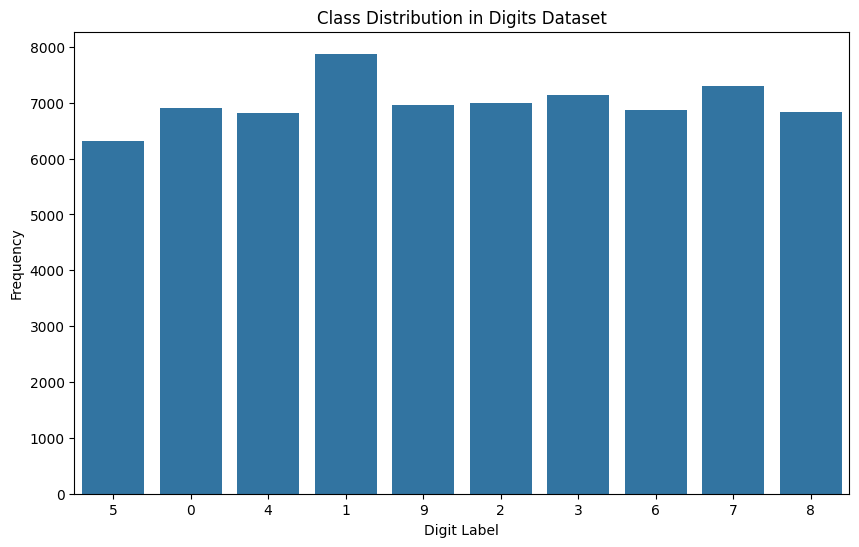

In [10]:
# create a bar chart for digit distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=mnist_digits.target)
plt.title('Class Distribution in Digits Dataset')
plt.xlabel('Digit Label')
plt.ylabel('Frequency')
plt.xticks(range(10))
plt.show()

This chart displays the frequency of each digits in the dataset. The distrubtion of the digits is well balanced.

# 4. Model Training and Evaluation <a class="anchor" id="train"></a>
We continue by feature scaling the dataset by normalizing the pixels values of the $ 28 \times 28 $ images into a range of $0$-$1$ by dividing them by $255$. We will also split the dataset into $60$% training, $20$% validation and $20$% training. The large size of the dataset allows us to allocate significant portions to training without compromising the size of the validation and test size. 

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

X = mnist_digits.data 
y = mnist_digits.target.astype(int) # convert from string to integer

# split the data into training + validation and test sets (60%, 40%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# split the training + validation set into separate training and validation sets (60%/40% of 40% = 24% for validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.4, random_state=42)

We will check the training and validation loss over iterations to find if our model converges.

Accuracy:  0.9130714285714285


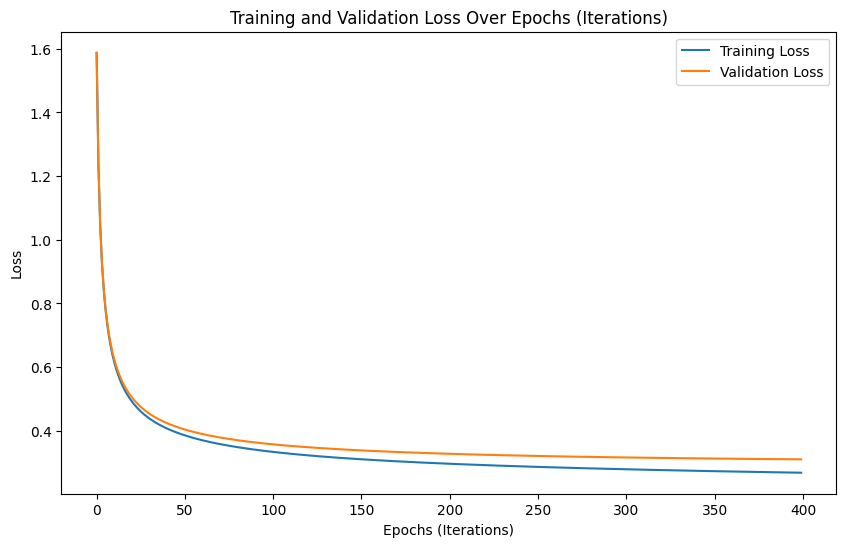

In [12]:
# normalize, feature scale our data.
scaler = StandardScaler()

# standardizes the training data to have a mean of 0 and a standard deviation of 1
X_train_scaled = scaler.fit_transform(X_train)
# transform the validation and test dataset using the same scaler
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# init the custom built SoftmaxRegression classifier with the 
# num_iter specifies the number of training iterations (epochs).
# learning_rate=0.1 sets the step size at each iteration while moving toward a minimum of the loss function.
clf = SoftMaxRegression(num_iters=400, learning_rate=0.1)

# fit the model to the normalized training data and
# also validate it using the scaled validation data.
clf.fit(X_train_scaled, y_train, X_val_scaled, y_val)

# predict labels for the scaled test data.
y_pred_softmax = clf.predict(X_test_scaled)
# compute the accuracy of the model on the test data and print it
accuracy_softmax = accuracy_score(y_test, y_pred_softmax)
print("Accuracy: ", accuracy_softmax)

# Plot the training and validation loss over the training epochs.
plt.figure(figsize=(10, 6))
plt.plot(clf.get_training_loss(), label='Training Loss')
plt.plot(clf.get_validation_loss(), label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs (Iterations)')
plt.xlabel('Epochs (Iterations)')
plt.ylabel('Loss')
plt.legend()
plt.show()

For our first evaluation, we will generate a confusion matrix. It's best to use a separate test set where the model is evaluated only once. This provides a clear and unbiased assessment of how the model performs on entirely unseen data

c:\Users\SHiFT\Documents\ML Paper\.conda\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


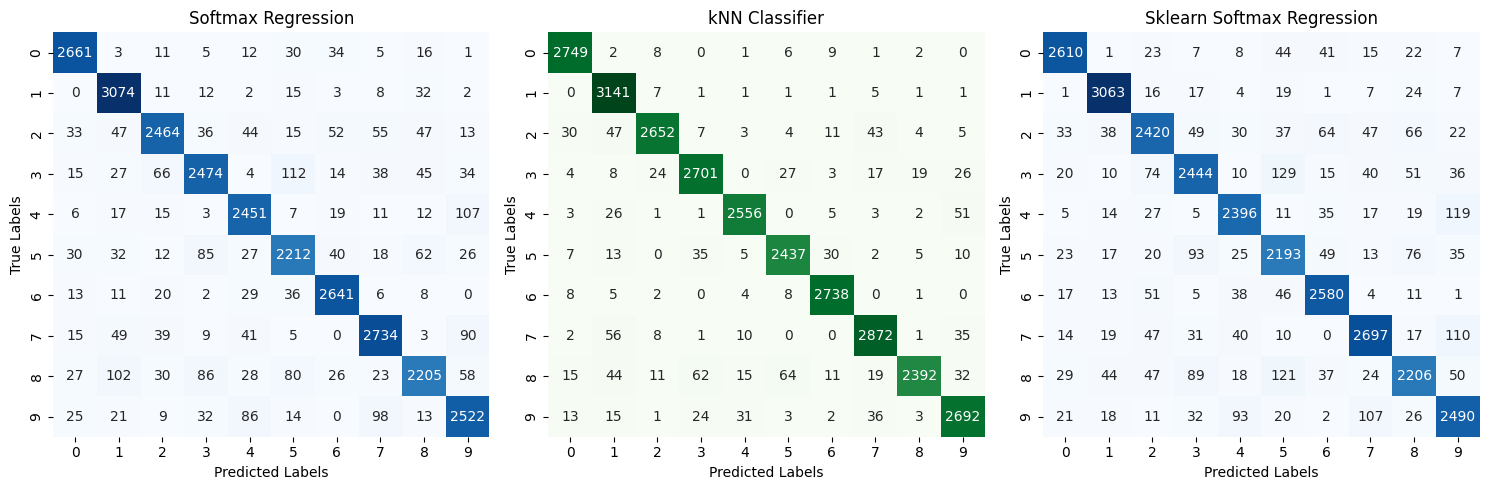

In [13]:
# initialize classifiers
softmax_clf = SoftMaxRegression(learning_rate=0.1, num_iters=200)
# initialize the kNN classfier with k = 5
knn_clf = KNeighborsClassifier(n_neighbors=5)
# init a Logistic Regression classifier for multinomial classification.
# The 'multinomial' option specifies that the model should use the multinomial logistic regression algorithm.
# The 'lbfgs' solver is an optimization algorithm.
# max_iter is 200 iterations which is the number of times the optimization algorithm will process the entire dataset.
sklearn_softmax_clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200)

# train the models on the training set
softmax_clf.fit(X_train_scaled, y_train)
knn_clf.fit(X_train, y_train)
sklearn_softmax_clf.fit(X_train_scaled, y_train)

# evaluate on the test set
predictions_softmax = softmax_clf.predict(X_test_scaled)
predictions_knn = knn_clf.predict(X_test)
predictions_sklearn_softmax = sklearn_softmax_clf.predict(X_test_scaled)

# compute the confusion matrices
cm_softmax = confusion_matrix(y_test, predictions_softmax)
cm_knn = confusion_matrix(y_test, predictions_knn)
cm_sklearn_softmax = confusion_matrix(y_test, predictions_sklearn_softmax)

# plot all three confusion matrices side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Confusion Matrix for Softmax Regression
sns.heatmap(cm_softmax, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
axes[0].set_title('Softmax Regression')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

# Confusion Matrix for kNN Classifier
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Greens', ax=axes[1], cbar=False)
axes[1].set_title('kNN Classifier')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')

# Confusion Matrix for Sklearn Softmax Regression
sns.heatmap(cm_sklearn_softmax, annot=True, fmt='d', cmap='Blues', ax=axes[2], cbar=False)
axes[2].set_title('Sklearn Softmax Regression')
axes[2].set_xlabel('Predicted Labels')
axes[2].set_ylabel('True Labels')

plt.tight_layout()
plt.show()

It appears that all three models perform relatively well, with high true positive rates for most digits. However, kNN seems to have slightly more true positives for several classes.

to assess the performence of our models, we will use accuracy, precision, recall and F1 metrics.

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# metrics dict will be in form of {'accuracy': [], 'precision': [], 'recall': [], 'f1': [] ... metric: []}
def compute_and_print_metrics(metrics, model_name):
    """
    Compute and prints the average metrics for a given model.

    Parameters:
    - metrics (dict): Dictionary containing lists of metric values for each fold of cross-validation.
    - model_name (str): Name of the model to display in the print statements.
    """
    # Init a dict to store the average values of the metrics
    avg_metrics = {}
    # loop through each metric in the given dict
    for metric, values in metrics.items():
        # compute the average value for this metric across all folds
        avg_value = np.mean(values)
        # add the average value to the avg_metrics dictionary
        avg_metrics[metric] = avg_value

    # print the model name
    print(f"\nAverage Metrics for {model_name}:")
    # loop through the avg_metrics dict and print each metric and its average value
    for metric, avg_value in avg_metrics.items():
        print(f"Average {metric}: {avg_value}")

We will also use $3$ Fold cross-validation, meaning each data points gets to be in the test set once and in the training set two times. This is suitable for both kNN and Softmax regression models for preventing overfitting since we are not just limited to a specific part of the data. We will not be using our custum-built kNN since it's computationally expensive and it's not optimized like the one of scikit-learn. 


In [15]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# initialize classifiers
softmax_clf = SoftMaxRegression(learning_rate=0.1, num_iters=200)
knn_clf = KNeighborsClassifier(n_neighbors=5)
sklearn_softmax_clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200)

# initialize k-Fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# init metrics dictis for each model
metrics_softmax = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
metrics_sklearn_softmax = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
metrics_knn = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # scale features for softmax regression
    X_train_fold_scaled = scaler.fit_transform(X_train_fold)
    X_test_fold_scaled = scaler.transform(X_test_fold)

    # Train and evaluate Softmax Regression
    softmax_clf.fit(X_train_fold_scaled, y_train_fold)
    predictions_softmax = softmax_clf.predict(X_test_fold_scaled)
    # compute and append the performence metrics
    metrics_softmax['accuracy'].append(accuracy_score(y_test_fold, predictions_softmax))
    metrics_softmax['precision'].append(precision_score(y_test_fold, predictions_softmax, average='weighted'))
    metrics_softmax['recall'].append(recall_score(y_test_fold, predictions_softmax, average='weighted'))
    metrics_softmax['f1'].append(f1_score(y_test_fold, predictions_softmax, average='weighted'))

    # Train and evaluate Sklearn Softmax Regression
    sklearn_softmax_clf.fit(X_train_fold_scaled, y_train_fold)
    predictions_sklearn_softmax = sklearn_softmax_clf.predict(X_test_fold_scaled)
    # compute and append the performence metrics
    metrics_sklearn_softmax['accuracy'].append(accuracy_score(y_test_fold, predictions_sklearn_softmax))
    metrics_sklearn_softmax['precision'].append(precision_score(y_test_fold, predictions_sklearn_softmax, average='weighted'))
    metrics_sklearn_softmax['recall'].append(recall_score(y_test_fold, predictions_sklearn_softmax, average='weighted'))
    metrics_sklearn_softmax['f1'].append(f1_score(y_test_fold, predictions_sklearn_softmax, average='weighted'))

    # Train and evaluate kNN
    knn_clf.fit(X_train_fold, y_train_fold)
    predictions_knn = knn_clf.predict(X_test_fold)
    # compute and append the performence metrics
    metrics_knn['accuracy'].append(accuracy_score(y_test_fold, predictions_knn))
    metrics_knn['precision'].append(precision_score(y_test_fold, predictions_knn, average='weighted'))
    metrics_knn['recall'].append(recall_score(y_test_fold, predictions_knn, average='weighted'))
    metrics_knn['f1'].append(f1_score(y_test_fold, predictions_knn, average='weighted'))


compute_and_print_metrics(metrics_softmax, "Softmax Regression")
compute_and_print_metrics(metrics_knn, "kNN Classifier")
compute_and_print_metrics(metrics_sklearn_softmax, "Sklearn Softmax Regression")

c:\Users\SHiFT\Documents\ML Paper\.conda\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\SHiFT\Documents\ML Paper\.conda\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht


Average Metrics for Softmax Regression:
Average accuracy: 0.9094000109832717
Average precision: 0.9091771260982267
Average recall: 0.9094000109832717
Average f1: 0.9089744107856047

Average Metrics for kNN Classifier:
Average accuracy: 0.9693857330484609
Average precision: 0.9696338245381432
Average recall: 0.9693857330484609
Average f1: 0.9693295871181752

Average Metrics for Sklearn Softmax Regression:
Average accuracy: 0.9109714356778461
Average precision: 0.9107381024548006
Average recall: 0.9109714356778461
Average f1: 0.910794453434041


In [16]:
print("metrics for Softmax Regression \n", metrics_softmax)
print("metrics for kNN Classifier \n", metrics_knn)
print("metrics for Sklearn Softmax Regression \n", metrics_sklearn_softmax)

metrics for Softmax Regression 
 {'accuracy': [0.9086311819662295, 0.9103844340633438, 0.9091844169202418], 'precision': [0.9084592183852422, 0.9101146176020917, 0.9089575423073464], 'recall': [0.9086311819662295, 0.9103844340633438, 0.9091844169202418], 'f1': [0.9081688779415986, 0.909963884180799, 0.9087904702344167]}
metrics for kNN Classifier 
 {'accuracy': [0.9680723407902632, 0.9707710110144431, 0.9693138473406763], 'precision': [0.9683469858935664, 0.9710063164683433, 0.9695481712525196], 'recall': [0.9680723407902632, 0.9707710110144431, 0.9693138473406763], 'f1': [0.9680010718424977, 0.970721142909416, 0.9692665466026117]}
metrics for Sklearn Softmax Regression 
 {'accuracy': [0.9104739864575297, 0.9117130244717782, 0.9107272961042301], 'precision': [0.9101861883142665, 0.9114662066272231, 0.9105619124229124], 'recall': [0.9104739864575297, 0.9117130244717782, 0.9107272961042301], 'f1': [0.9102510187998167, 0.9115292886154375, 0.9106030528868685]}


We can see the metrics are consistent for each model across for fold.

We will visualize the weights of the Softmax Regression model in a heatmap for interpretability for each class. This visualization can help us understand which parts of the images are most critical for the Softmax Regression model for classification decisions.

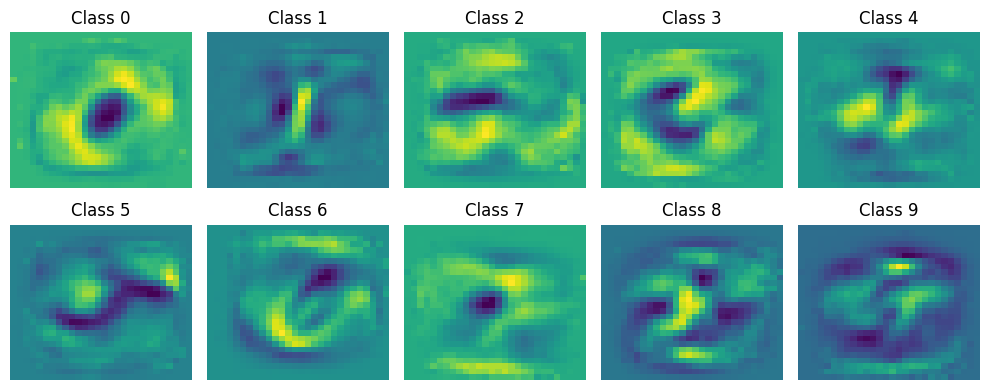

In [17]:
# get the number of classes in the softmax classifier
num_classes = softmax_clf.get_num_classes()
# Define the number of columns and rows for the subplot grid
# We will arrange the heatmaps in a grid of 2 rows and 5 columns
num_cols = 5 
num_rows = 2

# create a figure and a set of subplots.
# sets the width and height of each subplot.
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*2, num_rows*2))
# loop over each class to plot its corresponding weight heatmap
for i in range(num_classes):
    ax = axes[i // num_cols, i % num_cols]
    # visualize the weights of the softmax classifier for the current class using heatmap.
    # The weights are reshaped to 28x28 to match the image dimensions of the MNIST dataset.
    sns.heatmap(softmax_clf.weights[:, i].reshape(28, 28), ax=ax, cmap='viridis', cbar=False)
    ax.set_title(f'Class {i}')
    ax.axis('off') 

plt.tight_layout()
plt.show()

The plot above shows a heatmap for each image corresponding to one class of digit and the colors represent the strength and direction of the weights for each pixel:
- Bright yellow areas shows that the pixels that strongly positively influence the model's prediction for that class.
- dark blue areas shows that the pixels that have a strong negative influence or are less important for predicting that class.
- green to red areas shows that the pixels that have varying levels of influence on the model's decision.

The model seems to focus on the central regions for digits like $0$, $6$, $8$, and $9$, which are characterized by their central loops or curves. For digits like $1$, $7$, and $4$ the vertical lines are significant

# 5. Conclusion <a class="anchor" id="conclusion"></a>
In conclusion, this notebook focused on the implementation and analysis of two machine learning algorithms for digit classification: the k-Nearest Neighbors (kNN) and Softmax Regression. We began with data preprocessing and exploratory analysis, followed by the development and training of both models. And finally evaluation and visualization of the model performence. 